In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql import SparkSession
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

Sessão Spark (Não necessário para rodar no Databricks)

In [17]:
spark = SparkSession.builder.appName("Spark App").getOrCreate()

In [18]:
#  Datasets Kaggle (Rodar só uma vez)

# api = KaggleApi()
# api.authenticate()

# api.competition_download_files('demand-forecasting-kernels-only', path='datasets')

In [19]:
df = spark.read.csv('datasets/train.csv', header=True)

df.show()

+----------+-----+----+-----+
|      date|store|item|sales|
+----------+-----+----+-----+
|2013-01-01|    1|   1|   13|
|2013-01-02|    1|   1|   11|
|2013-01-03|    1|   1|   14|
|2013-01-04|    1|   1|   13|
|2013-01-05|    1|   1|   10|
|2013-01-06|    1|   1|   12|
|2013-01-07|    1|   1|   10|
|2013-01-08|    1|   1|    9|
|2013-01-09|    1|   1|   12|
|2013-01-10|    1|   1|    9|
|2013-01-11|    1|   1|    9|
|2013-01-12|    1|   1|    7|
|2013-01-13|    1|   1|   10|
|2013-01-14|    1|   1|   12|
|2013-01-15|    1|   1|    5|
|2013-01-16|    1|   1|    7|
|2013-01-17|    1|   1|   16|
|2013-01-18|    1|   1|    7|
|2013-01-19|    1|   1|   18|
|2013-01-20|    1|   1|   15|
+----------+-----+----+-----+
only showing top 20 rows



In [20]:
window3 = Window.orderBy('date').rowsBetween(-2,0)
window7 = Window.orderBy('date').rowsBetween(-6,0)
window30 = Window.orderBy('date').rowsBetween(-29,0)
window119 = Window.orderBy('date').rowsBetween(-119,0)
window360 = Window.orderBy('date').rowsBetween(-359,0)


df_with_sma = (
    df
    .filter((F.col('item') == 1) & (F.col('store')== 1))
    .withColumn('SMA_3', F.avg(F.col('sales')).over(window3))
    .withColumn('SMA_7', F.avg(F.col('sales')).over(window7))
    .withColumn('SMA_30', F.avg(F.col('sales')).over(window30))
    .withColumn('SMA_120', F.avg(F.col('sales')).over(window119))
    .withColumn('SMA_360', F.avg(F.col('sales')).over(window360))
)

df_with_sma.show()

+----------+-----+----+-----+------------------+------------------+------------------+------------------+------------------+
|      date|store|item|sales|             SMA_3|             SMA_7|            SMA_30|           SMA_120|           SMA_360|
+----------+-----+----+-----+------------------+------------------+------------------+------------------+------------------+
|2013-01-01|    1|   1|   13|              13.0|              13.0|              13.0|              13.0|              13.0|
|2013-01-02|    1|   1|   11|              12.0|              12.0|              12.0|              12.0|              12.0|
|2013-01-03|    1|   1|   14|12.666666666666666|12.666666666666666|12.666666666666666|12.666666666666666|12.666666666666666|
|2013-01-04|    1|   1|   13|12.666666666666666|             12.75|             12.75|             12.75|             12.75|
|2013-01-05|    1|   1|   10|12.333333333333334|              12.2|              12.2|              12.2|              12.2|


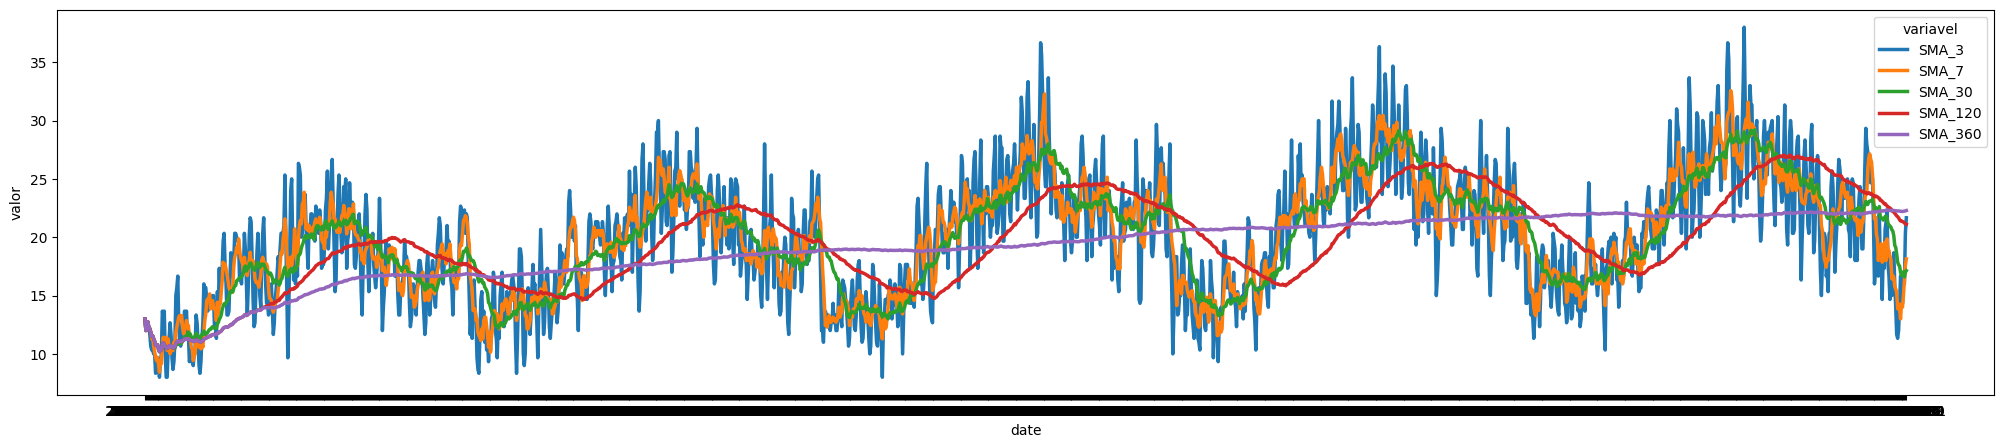

In [21]:
df_plot = df_with_sma.toPandas()

plt.figure(figsize=(25, 5))

plot = df_plot.melt(id_vars='date', value_vars=['SMA_3', 'SMA_7', 'SMA_30', 'SMA_120', 'SMA_360'], var_name='variavel', value_name='valor')

sns.lineplot(data=plot, x='date', y='valor', hue='variavel', linewidth=2.5)

plt.show()

In [35]:
df_plot['EMA_120'] = df_plot['sales'].ewm(span=120, adjust=False).mean()

df_plot['sales'] = pd.to_numeric(df_plot['sales'])

df_plot.dtypes

date        object
store       object
item        object
sales        int64
SMA_3      float64
SMA_7      float64
SMA_30     float64
SMA_120    float64
SMA_360    float64
EMA_7      float64
EMA_120    float64
dtype: object

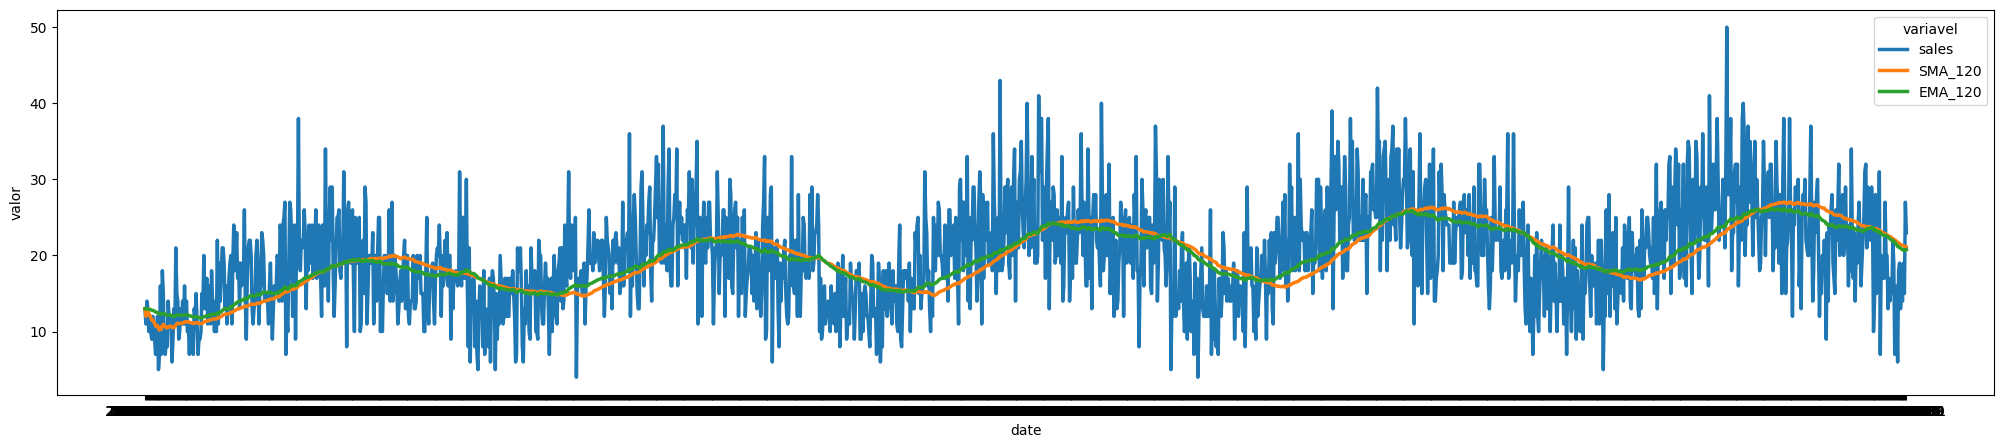

In [36]:
plt.figure(figsize=(25, 5))

plot = df_plot.melt(id_vars='date', value_vars=['sales','SMA_120', 'EMA_120'], var_name='variavel', value_name='valor')

sns.lineplot(data=plot, x='date', y='valor', hue='variavel', linewidth=2.5)

plt.show()